In [400]:
# !pip install seaborn
#Import all the needed libraries
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import re
from collections import Counter, defaultdict
# from wordcloud import WordCloud

In [448]:
file_list = ('icse22_mixed_v1.json','icse22_recent_v1.json','icse2022_mixed_v1.json','icse2022_recent_v4.json')
icse_tweets = []
for path in file_list:
    with open(path) as f:
        loaded_tweets = json.load(f)
        print(f"Loaded {len(loaded_tweets)} tweets from '{path}'")
        ids = [t['id'] for t in icse_tweets]
        for t in loaded_tweets:
            if t['id'] not in ids:
                icse_tweets.append(t)
        print(f"Gathered {len(icse_tweets)} tweets")

from pprint import pprint
pprint(icse_tweets[0])


Loaded 68 tweets from 'icse22_mixed_v1.json'
Gathered 68 tweets
Loaded 75 tweets from 'icse22_recent_v1.json'
Gathered 82 tweets
Loaded 388 tweets from 'icse2022_mixed_v1.json'
Gathered 470 tweets
Loaded 542 tweets from 'icse2022_recent_v4.json'
Gathered 642 tweets
{'contributors': None,
 'coordinates': None,
 'created_at': 'Thu Jun 02 11:11:32 +0000 2022',
 'display_text_range': [0, 140],
 'entities': {'hashtags': [{'indices': [14, 21], 'text': 'ICSE22'}],
              'symbols': [],
              'urls': [],
              'user_mentions': [{'id': 40829038,
                                 'id_str': '40829038',
                                 'indices': [3, 12],
                                 'name': 'ICSE',
                                 'screen_name': 'ICSEconf'}]},
 'favorite_count': 0,
 'favorited': False,
 'full_text': 'RT @ICSEconf: #ICSE22 just finished. But we have some memories '
              'here. Check out the virtual presentations on ICSE Youtube '
              'C

In [402]:
def is_RT(tweet):
    if 'retweeted_status' not in tweet:
        return False      
    else:
        return True

#Create a function to see if the tweet is a reply to a tweet of another user, if so return said user. 
def is_Reply_to(tweet):
    if 'in_reply_to_screen_name' not in tweet:
        return False      
    else:
        return tweet['in_reply_to_screen_name']

In [455]:
tweets = pd.DataFrame()
tweets['text'] = list(map(lambda tweet: tweet['full_text'] if 'extended_tweet' not in tweet else tweet['extended_tweet']['full_text'], icse_tweets))
tweets['Username'] = list(map(lambda tweet: tweet['user']['screen_name'], icse_tweets))
# tweets['timestamp'] = list(map(lambda tweet: tweet['created_at'], icse_tweets))
tweets['length'] = list(map(lambda tweet: len(tweet['full_text']) if'extended_tweet' not in tweet else len(tweet['extended_tweet']['full_text']), icse_tweets))
# tweets['location'] = list(map(lambda tweet: tweet['user']['location'], icse_tweets))
tweets['RT'] = list(map(is_RT, icse_tweets))
tweets['Reply'] = list(map(is_Reply_to, icse_tweets))
tweets['favorites'] = list(map(lambda tweet: tweet['favorite_count'], icse_tweets))
tweets['retweets'] = list(map(lambda tweet: tweet['retweet_count'], icse_tweets))
tweets['url'] = list(map(lambda t: f"https://twitter.com/{t['user']['screen_name']}/{t['id_str']}", icse_tweets))

In [456]:
tweets.head()

,text,Username,length,RT,Reply,favorites,retweets,url
0,RT @ICSEconf: #ICSE22 just finished. But we ha...,heiko_braun,140,True,None,0,3,https://twitter.com/heiko_braun/15323189946397...
1,RT @ICSEconf: #ICSE22 just finished. But we ha...,ivanmachado,140,True,None,0,3,https://twitter.com/ivanmachado/15321702057989...
2,RT @ICSEconf: #ICSE22 just finished. But we ha...,jeremy_bradbury,140,True,None,0,3,https://twitter.com/jeremy_bradbury/1532159481...
3,#ICSE22 just finished. But we have some memori...,ICSEconf,141,False,None,25,3,https://twitter.com/ICSEconf/1532120530068946951
4,RT @cestlemieux: Had a great time seeing every...,ubc_spl,140,True,None,0,1,https://twitter.com/ubc_spl/1532047024626880512


In [405]:
print(f"There are {tweets['Username'].nunique()} unique users in the dataset")

There are 298 unique users in the dataset


In [462]:
favorite_sorted_tweets = tweets.sort_values('favorites', ascending=False)
pd.set_option('display.max_colwidth', None)
favorite_sorted_tweets[['favorites','text','url']].head(10)

,favorites,text,url
70,140,Three WISE women @ICSEconf (with certificates to prove it). Thanks @davidlo2015 for taking the pic! #icse22 https://t.co/Oh5ha3FfnK,https://twitter.com/burnettmmosu/1529780667009073152
175,123,Our team at @MSFTResearch is hiring! We’re looking for folks at the intersection of AI &amp; software engineering to help make developers’ work better. You'll work closely with @saintesmsr and Dev Velocity Lab. DM for questions. https://t.co/sRtKhs4Jd8 #icseconf \n#msrconf #icse2022,https://twitter.com/tomzimmermann/1530700858865770496
252,98,Congrats to my undergraduate student Bella Laybourn for receiving the second prize in the ACM student research competition at #ICSE2022 for Mu2: Greybox Fuzzing with Mutation Analysis. Bella started this project as a sophomore student at CMU. Great job! https://t.co/nBHRLyzrao,https://twitter.com/moarbugs/1530282008852807681
167,90,"We got. ++ compliments on ⁦@ICSEconf⁩ #icse2022 program (thank you!). It was an amazing team effort (&gt;300 PC members)! Thank you all and to our fearless leadership team(some made it to Pittsburgh ⁦@mdipenta⁩ ⁦@abegel⁩ ⁦⁦@KellyBlincoe⁩ Jo, Tevfik, Frank) https://t.co/ZOI3CYxmap",https://twitter.com/DanaHDamian/1530743837382963200
184,86,"Thank you @sigsoft for sponsoring my child's travel to @ICSEconf. Tks also to all the empathetic smiles (even with eyes, when masked). Special tks to those who kindly approached me interested on replicating our study, and asking about my future plans. #nomaternitywall #ICSE2022 https://t.co/yoZUCi1Su5",https://twitter.com/biancatrink/1530616408463360003
243,85,Hanging out with other “Santos” at #ICSE2022. Academic relatives! https://t.co/mLXBYKdKiz,https://twitter.com/joannacss/1530303674941046791
543,85,Awesome students are awesome. Congratulations to @fang_hongbo @courtneyelta @SophieHCohen for distinguished paper awards at @ICSEconf #ICSE2022! Don’t miss their distinguished talks tomorrow. https://t.co/U0KiPoPNbs,https://twitter.com/b_vasilescu/1529502689561915394
506,85,Congratulations to the winners of the Distinguished Paper Award @ICSEconf 2022. #ICSE2022 https://t.co/mCKvuUNe2x,https://twitter.com/TDurschmid/1529649566877900800
639,66,"At ⁦@msrconf⁩! All masked, but it is great to speak to people in person. #msr2022 #icse2022 https://t.co/3Zrihy5kFr",https://twitter.com/avandeursen/1528728711960436736
422,64,"Chatting with @mairieli, @LFPaganini, and @PreethaChatterj at @ICSEconf.\n#ICSE2022 https://t.co/cydwWbp2F5",https://twitter.com/joannacss/1529895729019465756


In [470]:
retweet_sorted_tweets = tweets[~tweets['RT']].sort_values('retweets', ascending=False)
retweet_sorted_tweets[['retweets','text','url']].head(10)

,retweets,text,url
175,32,Our team at @MSFTResearch is hiring! We’re looking for folks at the intersection of AI &amp; software engineering to help make developers’ work better. You'll work closely with @saintesmsr and Dev Velocity Lab. DM for questions. https://t.co/sRtKhs4Jd8 #icseconf \n#msrconf #icse2022,https://twitter.com/tomzimmermann/1530700858865770496
372,14,"Good morning #icse2022 attendants! Would have loved to be there in person, but let me spread that we have openings for two well-resourced professorships in CS, esp. in programming languages (PL) and SE with PL focus. https://t.co/ZVlSX75QPj\nContact me if interested! /cc @ICSEconf",https://twitter.com/thorsten_berger/1530095636317720576
70,11,Three WISE women @ICSEconf (with certificates to prove it). Thanks @davidlo2015 for taking the pic! #icse22 https://t.co/Oh5ha3FfnK,https://twitter.com/burnettmmosu/1529780667009073152
506,10,Congratulations to the winners of the Distinguished Paper Award @ICSEconf 2022. #ICSE2022 https://t.co/mCKvuUNe2x,https://twitter.com/TDurschmid/1529649566877900800
278,9,"It takes you years to come up with a good research idea, says @AndreasZeller. If you’ve had one: we hire you. If you’ve had two, you get tenure. \n#icse2022",https://twitter.com/azaidman/1530252636934623235
325,7,"Yesterday, @PooyanJamshidi was presenting our work on studying how developers actually debug performance issues in configurable systems. https://t.co/5N9a20Jxfj I'm currently looking for a Postdoc for some follow up research. If interested, reach out #ICSE2022 https://t.co/m346aehGXt",https://twitter.com/p0nk/1530184647199625217
302,7,.@denaefordrobin on „A Tale of Two Cities: Software Developers Working from Home During the COVID-19 Pandemic“ with recommendations for remote onboarding and team productivity. 😷 @ICSEconf #icse2022 https://t.co/TPmHzFgMlo,https://twitter.com/chrisma0/1530206172623650816
243,6,Hanging out with other “Santos” at #ICSE2022. Academic relatives! https://t.co/mLXBYKdKiz,https://twitter.com/joannacss/1530303674941046791
455,6,Great job @oparry9 on presenting our developer survey on flaky tests at @ICSEconf. Preprint here if you are interested: https://t.co/3fcqcZxXbc #icse2022 https://t.co/tVY9bZdCQp,https://twitter.com/michaelhilton/1529843770392555520
344,6,"“Bots for pull requests: the good, the bad, and the promising” by @mairieli et al. at #icse2022 https://t.co/VErKPYsAJ5",https://twitter.com/azaidman/1530177321558228993


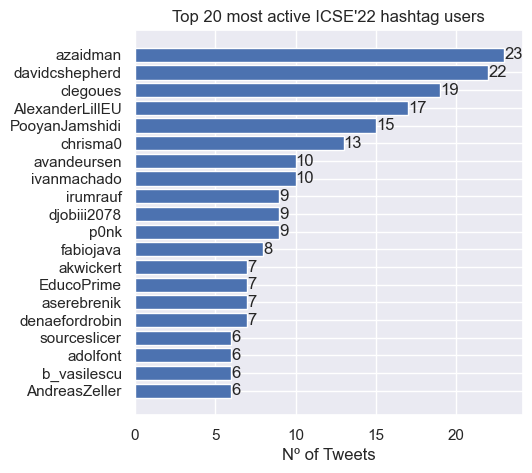

In [406]:
usertweets = tweets.groupby('Username')
#Top tweeting users
top_users = usertweets.count()['text'].sort_values(ascending = False)[:20].to_dict()

fig, ax = plt.subplots(figsize = (5,5))
sns.set_theme()
y_pos = np.arange(len(top_users.keys()))
ax.barh(y_pos, top_users.values(), align='center')
ax.set_yticks(y_pos, labels=top_users.keys())
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Nº of Tweets")
ax.set_title("Top 20 most active ICSE'22 hashtag users")
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()


In [464]:
#See the percentage of tweets from the initial set that are retweets
RT_tweets = tweets[tweets['RT'] == True]
print(f"The percentage of retweets is {round(len(RT_tweets)/len(tweets)*100)}% of all the tweets")
RT_tweets.head()

The percentage of retweets is 56% of all the tweets


,text,Username,length,RT,Reply,favorites,retweets,url
0,RT @ICSEconf: #ICSE22 just finished. But we have some memories here. Check out the virtual presentations on ICSE Youtube Channel. \n\nhttps:/…,heiko_braun,140,True,None,0,3,https://twitter.com/heiko_braun/1532318994639765506
1,RT @ICSEconf: #ICSE22 just finished. But we have some memories here. Check out the virtual presentations on ICSE Youtube Channel. \n\nhttps:/…,ivanmachado,140,True,None,0,3,https://twitter.com/ivanmachado/1532170205798989826
2,RT @ICSEconf: #ICSE22 just finished. But we have some memories here. Check out the virtual presentations on ICSE Youtube Channel. \n\nhttps:/…,jeremy_bradbury,140,True,None,0,3,https://twitter.com/jeremy_bradbury/1532159481156616197
4,RT @cestlemieux: Had a great time seeing everyone in person again (or for the first time) at #ICSE22 ☺️! Really nice to re-connect to commu…,ubc_spl,140,True,None,0,1,https://twitter.com/ubc_spl/1532047024626880512
7,RT @SeSa_Lab: Bronze medal at the #ICSE22 SRC! 🥉 Congrats to our very own @ManuelDeStefan0! 🚀,ManuelDeStefan0,93,True,None,0,3,https://twitter.com/ManuelDeStefan0/1530961586076123136


In [463]:
#See the percentage of tweets from the initial set that are replies #to tweets of another user:
Reply_tweets = tweets[tweets['Reply'].apply(type) == str]
print(f"The percentage of replies is {round(len(Reply_tweets)/len(tweets)*100)}% of all the tweets")
Reply_tweets.head()

The percentage of replies is 4% of all the tweets


,text,Username,length,RT,Reply,favorites,retweets,url
6,@clegoues @ICSEconf Negative here in London #icse22. /@igorsteinmacher https://t.co/lgaMXlIwEP,rchatley,94,False,clegoues,5,0,https://twitter.com/rchatley/1531896425814138887
32,"The first session of #ICSE22 started with great talks about learning for StackOverflow posts, improvements of API misuse detectors, and mining OSS skills from GitHub activities. https://t.co/U6K9SQLyrg",akwickert,201,False,akwickert,1,0,https://twitter.com/akwickert/1530191752400982019
33,Some notes about ML related papers presented on second day of #ICSE22 👇 https://t.co/4XCtycwxNq,akwickert,95,False,akwickert,0,0,https://twitter.com/akwickert/1530190761295224832
36,"Here is the link for the paper (Journal First Track, #ICSE22 ): https://t.co/JkHFvMUpx2",GulCalikli,87,False,GulCalikli,1,0,https://twitter.com/GulCalikli/1530189250230116353
62,@FoelliXde presents their paper TaintBench at @ICSEconf at the Program Analysis session. \n\n #icse22\n\ncc @LinghuiLuo @piskachev_ @manuelbenz3 Ivan Pashchenko @linuxfan91 @profbodden @benhermann Fabio Massacci https://t.co/lVqHTV5M23,akwickert,232,False,FoelliXde,13,4,https://twitter.com/akwickert/1529843973841375234


In [409]:
#Percentage of tweets from the initial set that have mentions and are not retweets:
mention_tweets = tweets[~tweets['text'].str.contains("RT") & tweets['text'].str.contains("@")]
print(f"The percentage of mentions is {round(len(mention_tweets)/len(tweets)*100)}% of all the tweets")

The percentage of mentions is 28% of all the tweets


In [410]:
#Tweets that are plain text tweets (No RT or mention)
plain_text_tweets = tweets[~tweets['text'].str.contains("@") & ~tweets['text'].str.contains("RT")]
print(f"The percentage of plain text tweets is {round(len(plain_text_tweets)/len(tweets)*100)}% of all the tweets")

The percentage of plain text tweets is 16% of all the tweets


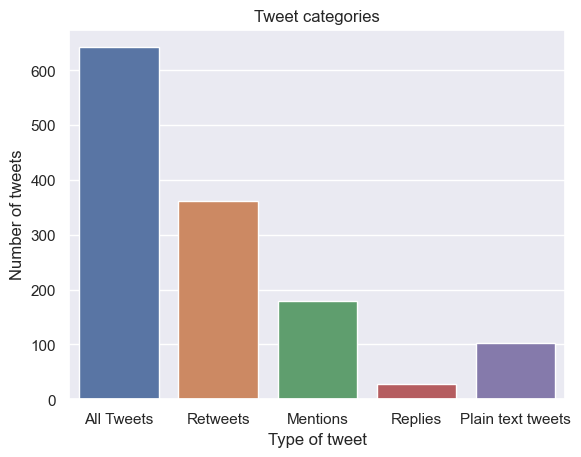

In [411]:
#Now we will plot all the different categories. Note that the reply #tweets are inside the mention tweets
len_list = [len(tweets), len(RT_tweets),len(mention_tweets), len(Reply_tweets), len(plain_text_tweets)]
item_list = ['All Tweets','Retweets', 'Mentions', 'Replies', 'Plain text tweets']
plt.figure()
sns.set_theme()
plt.title('Tweet categories')
plt.xlabel('Type of tweet')
plt.ylabel('Number of tweets')
sns.barplot(x=item_list, y=len_list)

plt.show()

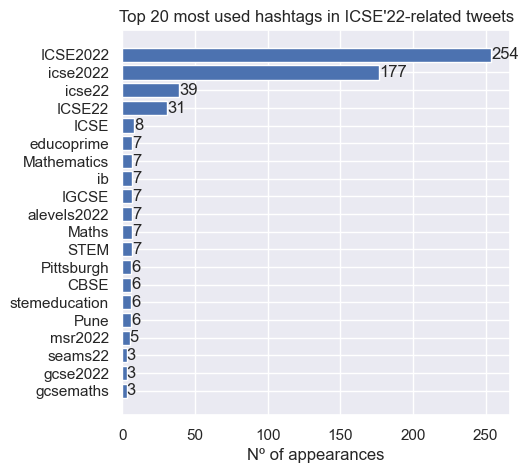

In [412]:
hashtags = Counter()
for tweet in icse_tweets:
    if ht_list := tweet['entities']['hashtags']:
        for ht_element in ht_list:
            hashtags.update({ht_element['text']: 1})
most_common = hashtags.most_common(20)

fig, ax = plt.subplots(figsize = (5,5))
y_pos = np.arange(len(most_common))
ax.barh(y_pos, [e[1] for e in most_common], align='center')
ax.set_yticks(y_pos, labels=[e[0] for e in most_common])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Nº of appearances")
ax.set_title("Top 20 most used hashtags in ICSE'22-related tweets")
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()


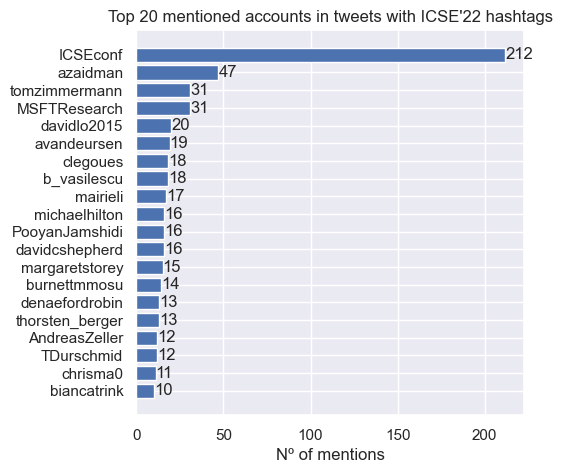

In [413]:
user_mentions = Counter()
for tweet in icse_tweets:
    if m_list := tweet['entities']['user_mentions']:
        for m_element in m_list:
            user_mentions.update({m_element['screen_name']: 1})
most_common = user_mentions.most_common(20)

fig, ax = plt.subplots(figsize = (5,5))
sns.set_theme()
y_pos = np.arange(len(most_common))
ax.barh(y_pos, [e[1] for e in most_common], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels([e[0] for e in most_common])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Nº of mentions")
ax.set_title("Top 20 mentioned accounts in tweets with ICSE'22 hashtags")
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()